# Changes of albedo, SMB, ice sheet thickness and surface ice velocity

Author: Ziqi Yin

Last modified: 2024 Nov 12

Table of contents:
* [Maps of albedo; SMB; ice sheet thickness; and surface ice velocity (column 1) and their changes at the CO2 stabilization period (column 2), the middle period (column 3) and the end of simulation (column 4).](#first-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
from cartopy.util import add_cyclic_point

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

# For unstructured grid
from holoviews.operation.datashader import datashade, rasterize, regrid
import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
import xesmf as xe

## Get data

### piControl

In [2]:
# CISM
ARCTIC_piControl_p4_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_piControl_p4_yearly.nc')['smb']
cism_x1 = ARCTIC_piControl_p4_smb_4km_yearly.x1
cism_y1 = ARCTIC_piControl_p4_smb_4km_yearly.y1
ARCTIC_piControl_p4_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_piControl_p4_yearly.nc')['thk']
ARCTIC_piControl_p4_velnorm_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_velnorm_piControl_p4_yearly.nc')['velnorm'][:,0,:,:]
cism_x0 = ARCTIC_piControl_p4_velnorm_yearly.x0
cism_y0 = ARCTIC_piControl_p4_velnorm_yearly.y0
ARCTIC_piControl_p4_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_piControl_p4_yearly.nc')['ice_sheet_mask']
ARCTIC_piControl_p4_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_piControl_p4_yearly.nc')['topg']

# CLM
ARCTIC_piControl_p4_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_piControl_p4_JJA.nc')['FSDS']
ARCTIC_piControl_p4_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_piControl_p4_JJA.nc')['FSR']

### 1pctCO2

In [3]:
# CISM
ARCTIC_1pctCO2_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_1pctCO2_yearly.nc')['smb']
ARCTIC_1pctCO2_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_1pctCO2_yearly.nc')['thk']
ARCTIC_1pctCO2_velnorm_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_velnorm_1pctCO2_yearly.nc')['velnorm'][:,0,:,:]
ARCTIC_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_1pctCO2_yearly.nc')['ice_sheet_mask']
ARCTIC_1pctCO2_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_1pctCO2_yearly.nc')['topg']

# CLM
ARCTIC_1pctCO2_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_1pctCO2_JJA.nc')['FSDS'] 
ARCTIC_1pctCO2_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_1pctCO2_JJA.nc')['FSR']

### 4xext

In [4]:
# CISM
ARCTIC_4xext_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_4xext_yearly.nc')['smb']
ARCTIC_4xext_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_4xext_yearly.nc')['thk']
ARCTIC_4xext_velnorm_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_velnorm_4xext_yearly.nc')['velnorm'][:,0,:,:]
ARCTIC_4xext_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_4xext_yearly.nc')['ice_sheet_mask']
ARCTIC_4xext_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_4xext_yearly.nc')['topg']

# Combine
ARCTIC_1pctCO2_4xext_smb_4km_yearly = xr.concat([ARCTIC_1pctCO2_smb_4km_yearly, ARCTIC_4xext_smb_4km_yearly], dim='time')
ARCTIC_1pctCO2_4xext_thk_yearly = xr.concat([ARCTIC_1pctCO2_thk_yearly, ARCTIC_4xext_thk_yearly], dim='time')
ARCTIC_1pctCO2_4xext_velnorm_yearly = xr.concat([ARCTIC_1pctCO2_velnorm_yearly, ARCTIC_4xext_velnorm_yearly], dim='time')
ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([ARCTIC_1pctCO2_ice_sheet_mask_yearly, ARCTIC_4xext_ice_sheet_mask_yearly], dim='time')
ARCTIC_1pctCO2_4xext_topg_yearly = xr.concat([ARCTIC_1pctCO2_topg_yearly, ARCTIC_4xext_topg_yearly], dim='time')

# CLM
ARCTIC_4xext_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_4xext_JJA.nc')['FSDS']
ARCTIC_4xext_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_4xext_JJA.nc')['FSR']

# Combine
ARCTIC_1pctCO2_4xext_FSDS_JJA = xr.concat([ARCTIC_1pctCO2_FSDS_JJA, ARCTIC_4xext_FSDS_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FSR_JJA = xr.concat([ARCTIC_1pctCO2_FSR_JJA, ARCTIC_4xext_FSR_JJA], dim='time')

### Area

In [5]:
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area_Arctic = f09_area.where(f09_area.yc > 60).values * Re**2
f09_area = f09_area.values * Re**2

ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file3)['area'] #[Radian2]
ARCTIC_area_Arctic = ARCTIC_area.where(ARCTIC_area.yc > 60).values * Re**2
ARCTIC_area = ARCTIC_area.values * Re**2

ARCTIC_lat = xr.open_dataset(ARCTIC_mask_file3).yc[0,:].values

### Mask

In [6]:
# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

### Scrip file

In [7]:
# Scrip files (contains grid information)
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

## Calculate

In [8]:
# Calculate
ARCTIC_piControlend_albedo_JJA_mean = (ARCTIC_piControl_p4_FSR_JJA[-20:,:] / ARCTIC_piControl_p4_FSDS_JJA[-20:,:]).mean(dim='time')
ARCTIC_stab_albedo_JJA_mean = (ARCTIC_1pctCO2_4xext_FSR_JJA[130:150,:] / ARCTIC_1pctCO2_4xext_FSDS_JJA[130:150,:]).mean(dim='time')
ARCTIC_mid_albedo_JJA_mean = (ARCTIC_1pctCO2_4xext_FSR_JJA[230:250,:] / ARCTIC_1pctCO2_4xext_FSDS_JJA[230:250,:]).mean(dim='time')
ARCTIC_end_albedo_JJA_mean = (ARCTIC_1pctCO2_4xext_FSR_JJA[330:,:] / ARCTIC_1pctCO2_4xext_FSDS_JJA[330:,:]).mean(dim='time')
ARCTIC_piControlend_GrIS_frac_JJA_mean = np.nanmean(ARCTIC_GrIS_mask_piControl[-20:,:], axis=0)
ARCTIC_stab_GrIS_frac_JJA_mean = np.nanmean(ARCTIC_GrIS_mask[130:150,:], axis=0)
ARCTIC_mid_GrIS_frac_JJA_mean = np.nanmean(ARCTIC_GrIS_mask[230:250,:], axis=0)
ARCTIC_end_GrIS_frac_JJA_mean = np.nanmean(ARCTIC_GrIS_mask[330:,:], axis=0)
ARCTIC_piControlend_smb_4km_yearly_mean = ARCTIC_piControl_p4_smb_4km_yearly[-20:,:,:].mean(dim='time')
ARCTIC_stab_smb_4km_yearly_mean = ARCTIC_1pctCO2_4xext_smb_4km_yearly[130:150,:,:].mean(dim='time')
ARCTIC_mid_smb_4km_yearly_mean = ARCTIC_1pctCO2_4xext_smb_4km_yearly[230:250,:,:].mean(dim='time')
ARCTIC_end_smb_4km_yearly_mean = ARCTIC_1pctCO2_4xext_smb_4km_yearly[330:,:,:].mean(dim='time')
ARCTIC_piControlend_thk_yearly_mean = ARCTIC_piControl_p4_thk_yearly[-20:,:,:].mean(dim='time')
ARCTIC_stab_thk_yearly_mean = ARCTIC_1pctCO2_4xext_thk_yearly[130:150,:,:].mean(dim='time')
ARCTIC_mid_thk_yearly_mean = ARCTIC_1pctCO2_4xext_thk_yearly[230:250,:,:].mean(dim='time')
ARCTIC_end_thk_yearly_mean = ARCTIC_1pctCO2_4xext_thk_yearly[330:,:,:].mean(dim='time')
ARCTIC_piControlend_velnorm_yearly_mean = ARCTIC_piControl_p4_velnorm_yearly[-20:,:,:].mean(dim='time')
ARCTIC_stab_velnorm_yearly_mean = ARCTIC_1pctCO2_4xext_velnorm_yearly[130:150,:,:].mean(dim='time')
ARCTIC_mid_velnorm_yearly_mean = ARCTIC_1pctCO2_4xext_velnorm_yearly[230:250,:,:].mean(dim='time')
ARCTIC_end_velnorm_yearly_mean = ARCTIC_1pctCO2_4xext_velnorm_yearly[330:,:,:].mean(dim='time')
ARCTIC_piControlend_ice_sheet_mask_yearly_mean = ARCTIC_piControl_p4_ice_sheet_mask_yearly[-20:,:,:].mean(dim='time')
ARCTIC_stab_ice_sheet_mask_yearly_mean = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[130:150,:,:].mean(dim='time')
ARCTIC_mid_ice_sheet_mask_yearly_mean = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[230:250,:,:].mean(dim='time')
ARCTIC_end_ice_sheet_mask_yearly_mean = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[330:,:,:].mean(dim='time')
ARCTIC_piControlend_topg_yearly_mean = ARCTIC_piControl_p4_topg_yearly[-20:,:,:].mean(dim='time')
ARCTIC_stab_topg_yearly_mean = ARCTIC_1pctCO2_4xext_topg_yearly[130:150,:,:].mean(dim='time')
ARCTIC_mid_topg_yearly_mean = ARCTIC_1pctCO2_4xext_topg_yearly[230:250,:,:].mean(dim='time')
ARCTIC_end_topg_yearly_mean = ARCTIC_1pctCO2_4xext_topg_yearly[330:,:,:].mean(dim='time')

# masked by ice_sheet_mask
ARCTIC_piControlend_albedo_JJA_mean_masked = ARCTIC_piControlend_albedo_JJA_mean.where(ARCTIC_piControlend_GrIS_frac_JJA_mean > 0)
ARCTIC_stab_albedo_JJA_mean_masked = ARCTIC_stab_albedo_JJA_mean.where(ARCTIC_stab_GrIS_frac_JJA_mean > 0)
ARCTIC_mid_albedo_JJA_mean_masked = ARCTIC_mid_albedo_JJA_mean.where(ARCTIC_mid_GrIS_frac_JJA_mean > 0)
ARCTIC_end_albedo_JJA_mean_masked = ARCTIC_end_albedo_JJA_mean.where(ARCTIC_end_GrIS_frac_JJA_mean > 0)
ARCTIC_piControlend_smb_4km_yearly_mean_masked = ARCTIC_piControlend_ice_sheet_mask_yearly_mean.where(ARCTIC_piControlend_ice_sheet_mask_yearly_mean > 0) * ARCTIC_piControlend_smb_4km_yearly_mean
ARCTIC_stab_smb_4km_yearly_mean_masked = ARCTIC_stab_ice_sheet_mask_yearly_mean.where(ARCTIC_stab_ice_sheet_mask_yearly_mean > 0) * ARCTIC_stab_smb_4km_yearly_mean
ARCTIC_mid_smb_4km_yearly_mean_masked = ARCTIC_mid_ice_sheet_mask_yearly_mean.where(ARCTIC_mid_ice_sheet_mask_yearly_mean > 0) * ARCTIC_mid_smb_4km_yearly_mean
ARCTIC_end_smb_4km_yearly_mean_masked = ARCTIC_end_ice_sheet_mask_yearly_mean.where(ARCTIC_end_ice_sheet_mask_yearly_mean > 0) * ARCTIC_end_smb_4km_yearly_mean
ARCTIC_piControlend_thk_yearly_mean_masked = ARCTIC_piControlend_ice_sheet_mask_yearly_mean.where(ARCTIC_piControlend_ice_sheet_mask_yearly_mean > 0) * ARCTIC_piControlend_thk_yearly_mean
ARCTIC_stab_thk_yearly_mean_masked = ARCTIC_stab_ice_sheet_mask_yearly_mean.where(ARCTIC_stab_ice_sheet_mask_yearly_mean > 0) * ARCTIC_stab_thk_yearly_mean
ARCTIC_mid_thk_yearly_mean_masked = ARCTIC_mid_ice_sheet_mask_yearly_mean.where(ARCTIC_mid_ice_sheet_mask_yearly_mean > 0) * ARCTIC_mid_thk_yearly_mean
ARCTIC_end_thk_yearly_mean_masked = ARCTIC_end_ice_sheet_mask_yearly_mean.where(ARCTIC_end_ice_sheet_mask_yearly_mean > 0) * ARCTIC_end_thk_yearly_mean

## Interp and mask

https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html

https://github.com/JiaweiZhuang/xESMF/issues/24

In [9]:
# Interp ice sheet mask from cism_x1/y1 to cism_x0/y0 for velnorm
ARCTIC_piControlend_ice_sheet_mask_yearly_mean0 = ARCTIC_piControlend_ice_sheet_mask_yearly_mean.interp(x1=cism_x0, y1=cism_y0, method='linear')
ARCTIC_stab_ice_sheet_mask_yearly_mean0 = ARCTIC_stab_ice_sheet_mask_yearly_mean.interp(x1=cism_x0, y1=cism_y0, method='linear')
ARCTIC_mid_ice_sheet_mask_yearly_mean0 = ARCTIC_mid_ice_sheet_mask_yearly_mean.interp(x1=cism_x0, y1=cism_y0, method='linear')
ARCTIC_end_ice_sheet_mask_yearly_mean0 = ARCTIC_end_ice_sheet_mask_yearly_mean.interp(x1=cism_x0, y1=cism_y0, method='linear')

In [10]:
ARCTIC_piControlend_velnorm_yearly_mean_masked = ARCTIC_piControlend_velnorm_yearly_mean.where(ARCTIC_piControlend_ice_sheet_mask_yearly_mean0 > 0)
ARCTIC_stab_velnorm_yearly_mean_masked = ARCTIC_stab_velnorm_yearly_mean.where(ARCTIC_stab_ice_sheet_mask_yearly_mean0 > 0)
ARCTIC_mid_velnorm_yearly_mean_masked = ARCTIC_mid_velnorm_yearly_mean.where(ARCTIC_mid_ice_sheet_mask_yearly_mean0 > 0)
ARCTIC_end_velnorm_yearly_mean_masked = ARCTIC_end_velnorm_yearly_mean.where(ARCTIC_end_ice_sheet_mask_yearly_mean0 > 0)

In [11]:
# Mask the other variables
ARCTIC_piControlend_albedo_JJA_mean_masked = ARCTIC_piControlend_albedo_JJA_mean.where(ARCTIC_piControlend_GrIS_frac_JJA_mean > 0)
ARCTIC_stab_albedo_JJA_mean_masked = ARCTIC_stab_albedo_JJA_mean.where(ARCTIC_stab_GrIS_frac_JJA_mean > 0)
ARCTIC_mid_albedo_JJA_mean_masked = ARCTIC_mid_albedo_JJA_mean.where(ARCTIC_mid_GrIS_frac_JJA_mean > 0)
ARCTIC_end_albedo_JJA_mean_masked = ARCTIC_end_albedo_JJA_mean.where(ARCTIC_end_GrIS_frac_JJA_mean > 0)
ARCTIC_piControlend_smb_4km_yearly_mean_masked = ARCTIC_piControlend_smb_4km_yearly_mean.where(ARCTIC_piControlend_ice_sheet_mask_yearly_mean > 0)
ARCTIC_stab_smb_4km_yearly_mean_masked = ARCTIC_stab_smb_4km_yearly_mean.where(ARCTIC_stab_ice_sheet_mask_yearly_mean > 0)
ARCTIC_mid_smb_4km_yearly_mean_masked = ARCTIC_mid_smb_4km_yearly_mean.where(ARCTIC_mid_ice_sheet_mask_yearly_mean > 0)
ARCTIC_end_smb_4km_yearly_mean_masked = ARCTIC_end_smb_4km_yearly_mean.where(ARCTIC_end_ice_sheet_mask_yearly_mean > 0)
ARCTIC_piControlend_thk_yearly_mean_masked = ARCTIC_piControlend_thk_yearly_mean.where(ARCTIC_piControlend_ice_sheet_mask_yearly_mean > 0)
ARCTIC_stab_thk_yearly_mean_masked = ARCTIC_stab_thk_yearly_mean.where(ARCTIC_stab_ice_sheet_mask_yearly_mean > 0)
ARCTIC_mid_thk_yearly_mean_masked = ARCTIC_mid_thk_yearly_mean.where(ARCTIC_mid_ice_sheet_mask_yearly_mean > 0)
ARCTIC_end_thk_yearly_mean_masked = ARCTIC_end_thk_yearly_mean.where(ARCTIC_end_ice_sheet_mask_yearly_mean > 0)

## Prepare for plotting SE grids

In [12]:
# Modified from the Plot_2D() function with link below
def get_var_verts(scrip_fname, var_in):

    # Read scrip file in case of SE model output
    ds_scrip = xr.open_dataset(scrip_fname)
    corner_lon = np.copy(ds_scrip.grid_corner_lon.values)
    corner_lat = np.copy(ds_scrip.grid_corner_lat.values)
    center_lon = np.copy(ds_scrip.grid_center_lon.values)
    center_lat = np.copy(ds_scrip.grid_center_lat.values)

    var0 = var_in # [ ]
    var = np.copy(var0.values)
    lon_range = [-180, 180]

    if ((np.min(lon_range) < 0) & (np.max(corner_lon) > 180)):
        corner_lon[corner_lon > 180.] -= 360.

    # set vertices for SE model output
    lons_corners = np.copy(corner_lon.reshape(corner_lon.shape[0], corner_lon.shape[1],1))
    lats_corners = np.copy(corner_lat.reshape(corner_lat.shape[0], corner_lat.shape[1],1))
    lons_corners[lons_corners > 180.] -= 360
    center_lon[center_lon > 180.] -= 360

    lons_corners_add = []
    lats_corners_add = []
    var_add = []
    # For longitudes -180, 180
    for i, cenlon in enumerate(center_lon):
        lon_maxmin = np.max(lons_corners[i,:,:]) - \
                     np.min(lons_corners[i,:,:])
        if (lon_maxmin > 180):
            if np.mean(lons_corners[i,:,:]) <= 0:
                inds2 = np.where(lons_corners[i,:,:] < 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = 180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] > 0)[0]
                lons_corners[i,inds] = -180.

                var_add.append(var[i])

            elif np.mean(lons_corners[i,:,:]) > 0:
                inds2 = np.where(lons_corners[i,:,:] > 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = -180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] < 0)[0]
                lons_corners[i,inds] = 180.

                var_add.append(var[i])

    lons_corners = np.concatenate((lons_corners, np.array(lons_corners_add)), axis=0)
    lats_corners = np.concatenate((lats_corners, np.array(lats_corners_add)), axis=0)
    var = np.concatenate((var, np.array(var_add)), axis=0)

    verts = np.concatenate((lons_corners, lats_corners), axis=2)
    
    return var, verts

In [13]:
ARCTIC_piControlend_albedo_JJA_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_piControlend_albedo_JJA_mean_masked)[0]
ARCTIC_piControlend_albedo_JJA_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_piControlend_albedo_JJA_mean_masked)[1]
ARCTIC_stab_albedo_JJA_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_stab_albedo_JJA_mean_masked)[0]
ARCTIC_stab_albedo_JJA_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_stab_albedo_JJA_mean_masked)[1]
ARCTIC_mid_albedo_JJA_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_mid_albedo_JJA_mean_masked)[0]
ARCTIC_mid_albedo_JJA_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_mid_albedo_JJA_mean_masked)[1]
ARCTIC_end_albedo_JJA_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_end_albedo_JJA_mean_masked)[0]
ARCTIC_end_albedo_JJA_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_end_albedo_JJA_mean_masked)[1]

In [14]:
# Dictionary declaration for keywords in external function call
kwd_polycollection = {}
kwd_polycollection['edgecolor'] = 'face'
#kwd_polycollection['norm'] = \
#                    matplotlib.colors.SymLogNorm( linthresh=self.linthresh,
#                                                  linscale=self.linscale,
#                                                  vmin=self.cmin, vmax=self.cmax )

## Get contour line

In [15]:
# year 0
ARCTIC_piControl_stopg_yr0 = ARCTIC_piControl_p4_topg_yearly[-1] + ARCTIC_piControl_p4_thk_yearly[-1]
ARCTIC_piControl_velnorm_yr0 = ARCTIC_piControl_p4_velnorm_yearly[-1] + ARCTIC_piControl_p4_velnorm_yearly[-1]

# year 150
ARCTIC_1pctCO2_4xext_stopg_yr150 = ARCTIC_1pctCO2_4xext_topg_yearly[149] + ARCTIC_1pctCO2_4xext_thk_yearly[149]
ARCTIC_1pctCO2_4xext_velnorm_yr150 = ARCTIC_1pctCO2_4xext_velnorm_yearly[149] + ARCTIC_1pctCO2_4xext_velnorm_yearly[149]

# year 250
ARCTIC_1pctCO2_4xext_stopg_yr250 = ARCTIC_1pctCO2_4xext_topg_yearly[249] + ARCTIC_1pctCO2_4xext_thk_yearly[249]
ARCTIC_1pctCO2_4xext_velnorm_yr250 = ARCTIC_1pctCO2_4xext_velnorm_yearly[249] + ARCTIC_1pctCO2_4xext_velnorm_yearly[249]

# year 350
ARCTIC_1pctCO2_4xext_stopg_yr350 = ARCTIC_1pctCO2_4xext_topg_yearly[-1] + ARCTIC_1pctCO2_4xext_thk_yearly[-1]
ARCTIC_1pctCO2_4xext_velnorm_yr350 = ARCTIC_1pctCO2_4xext_velnorm_yearly[-1] + ARCTIC_1pctCO2_4xext_velnorm_yearly[-1]

In [16]:
## Masked by ice_sheet_mask
# year 0
ARCTIC_piControl_stopg_yr0_masked = ARCTIC_piControl_p4_ice_sheet_mask_yearly[-1].where(ARCTIC_piControl_p4_ice_sheet_mask_yearly[-1] > 0) * ARCTIC_piControl_stopg_yr0

# year 150
ARCTIC_1pctCO2_4xext_stopg_yr150_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[149].where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[149] > 0) * ARCTIC_1pctCO2_4xext_stopg_yr150

# year 250
ARCTIC_1pctCO2_4xext_stopg_yr250_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[249].where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[249] > 0) * ARCTIC_1pctCO2_4xext_stopg_yr250

# year 350
ARCTIC_1pctCO2_4xext_stopg_yr350_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[-1].where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[-1] > 0) * ARCTIC_1pctCO2_4xext_stopg_yr350

In [17]:
# Interp ice sheet mask from cism_x1/y1 to cism_x0/y0 for velnorm
ARCTIC_piControl_p4_ice_sheet_mask_year0 = ARCTIC_piControl_p4_ice_sheet_mask_yearly[-1].interp(x1=cism_x0, y1=cism_y0, method='linear')
ARCTIC_1pctCO2_4xext_ice_sheet_mask_year150 = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[149].interp(x1=cism_x0, y1=cism_y0, method='linear')
ARCTIC_1pctCO2_4xext_ice_sheet_mask_year250 = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[249].interp(x1=cism_x0, y1=cism_y0, method='linear')
ARCTIC_1pctCO2_4xext_ice_sheet_mask_year350 = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[-1].interp(x1=cism_x0, y1=cism_y0, method='linear')

In [18]:
## Masked by ice_sheet_mask
# year 0
ARCTIC_piControl_velnorm_yr0_masked = ARCTIC_piControl_p4_ice_sheet_mask_year0.where(ARCTIC_piControl_p4_ice_sheet_mask_year0 > 0) * ARCTIC_piControl_velnorm_yr0

# year 150
ARCTIC_1pctCO2_4xext_velnorm_yr150_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_year150.where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_year150 > 0) * ARCTIC_1pctCO2_4xext_velnorm_yr150

# year 250
ARCTIC_1pctCO2_4xext_velnorm_yr250_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_year250.where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_year250 > 0) * ARCTIC_1pctCO2_4xext_velnorm_yr250

# year 350
ARCTIC_1pctCO2_4xext_velnorm_yr350_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_year350.where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_year350 > 0) * ARCTIC_1pctCO2_4xext_velnorm_yr350

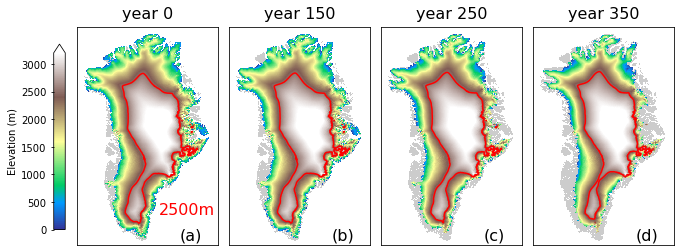

In [19]:
fig = plt.figure(figsize = (10.7,4))
gs=GridSpec(1,4)
plt.rcParams['axes.titlepad'] =14

size_label = 10
size_title = 16
width_line = 1.5

cmap1 = plt.cm.terrain

elev_con = 2500

#--------------------------------------------- yr 0 ----------------------------------------------------
ax1 = plt.subplot(gs[0])
im1 = ax1.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im1 = ax1.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_stopg_yr0_masked, cmap=cmap1, vmin=0, vmax=3200)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax1.text(500000, -3330000, '(a)', fontsize=size_title)
ax1.text(260000, -3000000, str(elev_con)+'m', fontsize=size_title, color='red')
ax1.set_title('year 0', pad=9, fontsize=size_title)

ctr1 = ax1.contour(cism_x1, cism_y1, ARCTIC_piControl_stopg_yr0_masked, levels=[elev_con], colors=['red'], linewidths=width_line)#, transform = crs_ll)#, norm=norm3)

# colorbar
cbar_ax1 = fig.add_axes([0.095, 0.178, 0.015, 0.644])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', extend='max')
cb1.set_label(label='Elevation (m)', size=size_label)
cb1.ax.tick_params(labelsize=size_label)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

#--------------------------------------------- yr 150 ----------------------------------------------------
ax2 = plt.subplot(gs[1])
im2 = ax2.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im2 = ax2.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr150_masked, cmap=cmap1, vmin=0, vmax=3200)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.text(500000, -3330000, '(b)', fontsize=size_title)
ax2.set_title('year 150', pad=9, fontsize=size_title)

ctr2 = ax2.contour(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr150_masked, levels=[elev_con], colors=['red'], linewidths=width_line)

#--------------------------------------------- yr 250 ----------------------------------------------------
ax3 = plt.subplot(gs[2])
im3 = ax3.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im3 = ax3.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr250_masked, cmap=cmap1, vmin=0, vmax=3200)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax3.text(500000, -3330000, '(c)', fontsize=size_title)
ax3.set_title('year 250', pad=9, fontsize=size_title)

ctr3 = ax3.contour(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr250_masked, levels=[elev_con], colors=['red'], linewidths=width_line)

#--------------------------------------------- yr 350 ----------------------------------------------------
ax4 = plt.subplot(gs[3])
im4 = ax4.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im4 = ax4.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr350_masked, cmap=cmap1, vmin=0, vmax=3200)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4.text(500000, -3330000, '(d)', fontsize=size_title)
ax4.set_title('year 350', pad=9, fontsize=size_title)

ctr4 = ax4.contour(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr350_masked, levels=[elev_con], colors=['red'], linewidths=width_line)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.08,
                    hspace=0.03)

#plt.savefig(home_dir+'dynamic_GrIS/github/plot/Map_elev_contour2500_ARCTIC.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [20]:
## Get the ELA contour line coordinates
p1 = ctr1.collections[0].get_paths() # xx lines
p2 = ctr2.collections[0].get_paths()
p3 = ctr3.collections[0].get_paths()
p4 = ctr4.collections[0].get_paths()

### Values

In [32]:
## Select the nearest grid point
p1_x = p1[0].vertices[:,0]
p1_y = p1[0].vertices[:,1]

p1_x0 = p1_x * 0
p1_y0 = p1_x * 0
p1_velnorm_PI = p1_x * 0
p1_velnorm_stab = p1_x * 0
p1_velnorm_mid = p1_x * 0
p1_velnorm_end = p1_x * 0

for i in range(len(p1_x)):
    p1_velnorm_PI[i] = ARCTIC_piControlend_velnorm_yearly_mean_masked.sel(y0=p1_y[i], x0=p1_x[i], method='nearest')
    p1_x0[i] = ARCTIC_piControlend_velnorm_yearly_mean_masked.sel(y0=p1_y[i], x0=p1_x[i], method='nearest').x0
    p1_y0[i] = ARCTIC_piControlend_velnorm_yearly_mean_masked.sel(y0=p1_y[i], x0=p1_x[i], method='nearest').y0
    p1_velnorm_stab[i] = ARCTIC_stab_velnorm_yearly_mean_masked.sel(y0=p1_y[i], x0=p1_x[i], method='nearest')
    p1_velnorm_mid[i] = ARCTIC_mid_velnorm_yearly_mean_masked.sel(y0=p1_y[i], x0=p1_x[i], method='nearest')
    p1_velnorm_end[i] = ARCTIC_end_velnorm_yearly_mean_masked.sel(y0=p1_y[i], x0=p1_x[i], method='nearest')

In [33]:
# Averaged velocity (remove duplicated grids and weight by grid area here)

p1_velnorm_PI_mean = np.mean(np.unique(p1_velnorm_PI))
p1_velnorm_stab_mean = np.mean(np.unique(p1_velnorm_stab))
p1_velnorm_mid_mean = np.mean(np.unique(p1_velnorm_mid))
p1_velnorm_end_mean = np.mean(np.unique(p1_velnorm_end))

print('PI: ', p1_velnorm_PI_mean)
print('stab: ', p1_velnorm_stab_mean)
print('mid: ', p1_velnorm_mid_mean)
print('end: ', p1_velnorm_end_mean)

PI:  34.72856182692563
stab:  35.94410811286286
mid:  42.25305536524261
end:  52.88495883895072


In [34]:
print('yr150: ', (p1_velnorm_stab_mean-p1_velnorm_PI_mean)/p1_velnorm_PI_mean*100)
print('yr250: ', (p1_velnorm_mid_mean-p1_velnorm_PI_mean)/p1_velnorm_PI_mean*100)
print('yr350: ', (p1_velnorm_end_mean-p1_velnorm_PI_mean)/p1_velnorm_PI_mean*100)

yr150:  3.5001342468342473
yr250:  21.666585491838934
yr350:  52.280877919765004


## Plot

In [21]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

In [22]:
# colorbar 1
cmap1 = plt.cm.rainbow_r
bounds1 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
norm1 = colors.BoundaryNorm(bounds1, cmap1.N)
# colorbar 4
cmap4 = plt.cm.RdBu
bounds4 = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
norm4 = colors.BoundaryNorm(bounds4, cmap4.N, extend='both')

# colorbar 5
cmap5 = plt.cm.RdBu
bounds5 = [-5000, -2000, -1000, -500, -200, -100, 0, 100, 200, 500, 1000, 2000, 5000]
norm5 = colors.BoundaryNorm(bounds5, cmap5.N, extend='both')
# colorbar 8
cmap8 = plt.cm.RdBu
bounds8 = [-5000, -2000, -1000, -500, -200, -100, -50, -20, -10, 0, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
norm8 = colors.BoundaryNorm(bounds8, cmap8.N, extend='both')

# colorbar 9
cmap9 = plt.cm.YlGnBu_r
cmap9.set_over('ivory')
bounds9 = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500]
norm9 = colors.BoundaryNorm(bounds9, cmap9.N)
# colorbar 12
cmap12 = plt.cm.RdBu
bounds12 = [-1000, -500, -200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
norm12 = colors.BoundaryNorm(bounds12, cmap12.N, extend='both')

# colorbar 13
cmap13 = plt.cm.viridis
cmap13.set_over('yellow')
cmap13.set_under('black')
bounds13 = [0.5, 1.5, 3, 5.5, 10, 15, 30, 60, 100, 150, 300, 600, 1000]
norm13 = colors.BoundaryNorm(bounds13, cmap13.N)
# colorbar 16
cmap16 = plt.cm.RdBu
bounds16 = [-500, -200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20, 50, 100, 200, 500]
norm16 = colors.BoundaryNorm(bounds16, cmap16.N, extend='both')

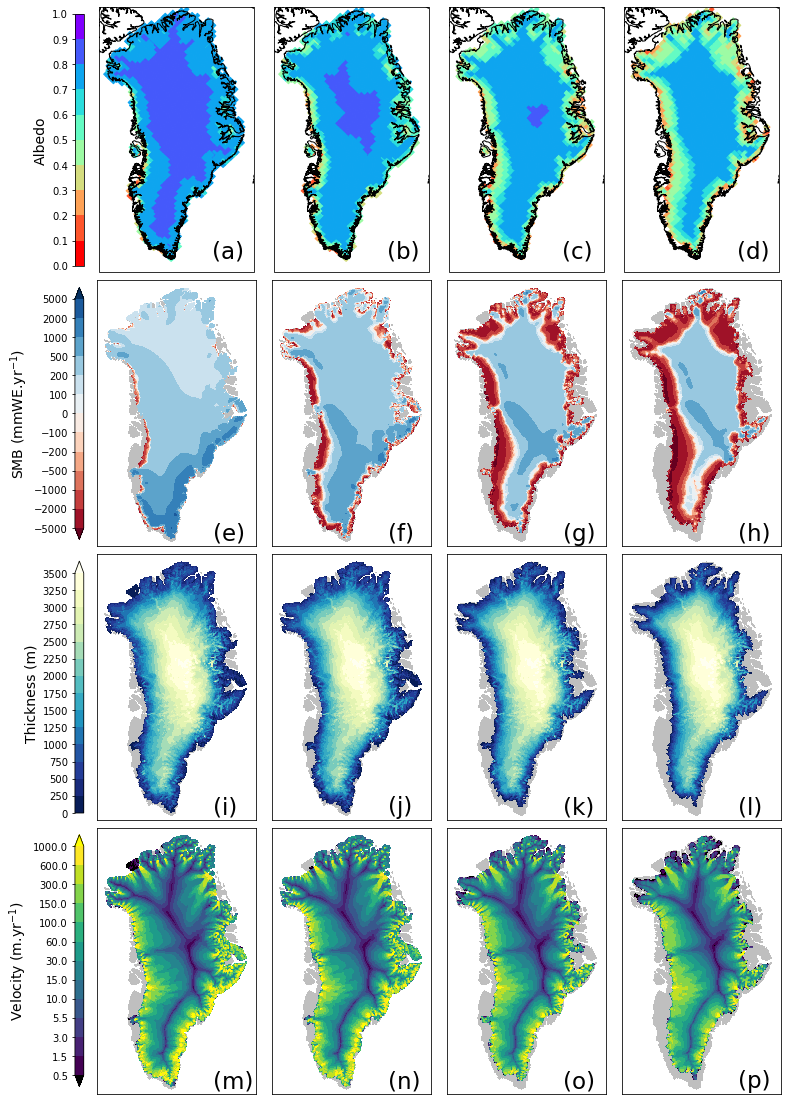

In [17]:
fig = plt.figure(figsize = (12.26,20))
gs=GridSpec(4,4)
plt.rcParams['axes.titlepad'] =14

#---------------------------------------------albedo----------------------------------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.5, -29.5, 58, 84])
ax1.coastlines(resolution='10m', zorder=7)
im1 = PolyCollection(ARCTIC_piControlend_albedo_JJA_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im1.set_array(ARCTIC_piControlend_albedo_JJA_var)
ax1.add_collection(im1)
ax1.text(500000, -3330000, '(a)', fontsize=23)

# colorbar
cbar_ax1 = fig.add_axes([0.1, 0.7, 0.01, 0.175])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', boundaries=bounds1, ticks=bounds1)
cb1.set_label(label='Albedo', size=14)
cb1.ax.tick_params(labelsize=10)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56.5, -29.5, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = PolyCollection(ARCTIC_stab_albedo_JJA_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im2.set_array(ARCTIC_stab_albedo_JJA_var)
ax2.add_collection(im2)
ax2.text(500000, -3330000, '(b)', fontsize=23)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56.5, -29.5, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = PolyCollection(ARCTIC_mid_albedo_JJA_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im3.set_array(ARCTIC_mid_albedo_JJA_var)
ax3.add_collection(im3)
ax3.text(500000, -3330000, '(c)', fontsize=23)

ax4 = plt.subplot(gs[3], projection=polar_stereographic)
ax4.set_extent([-56.5, -29.5, 58, 84])
ax4.coastlines(resolution='10m', zorder=7)
im4 = PolyCollection(ARCTIC_end_albedo_JJA_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im4.set_array(ARCTIC_end_albedo_JJA_var)
ax4.add_collection(im4)
ax4.text(500000, -3330000, '(d)', fontsize=23)

#---------------------------------------------smb----------------------------------------------------
ax5 = plt.subplot(gs[4])
im5 = ax5.contourf(cism_x1, cism_y1, ARCTIC_piControlend_topg_yearly_mean.where(ARCTIC_piControlend_topg_yearly_mean>0).where(ARCTIC_piControlend_topg_yearly_mean<0, other=1), cmap='gray_r')
im5 = ax5.contourf(cism_x1, cism_y1, ARCTIC_piControlend_smb_4km_yearly_mean_masked, cmap=cmap5, norm=norm5, levels=bounds5, extend='both')
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(500000, -3330000, '(e)', fontsize=23)

# colorbar
cbar_ax5 = fig.add_axes([0.1, 0.51, 0.01, 0.175])
cb5 = fig.colorbar(im5, cax=cbar_ax5, orientation='vertical', boundaries=[-6000]+bounds5+[6000], ticks=bounds5)
cb5.set_label(label='SMB (mmWE.$\mathregular{yr^{-1}}$)', size=14)
cb5.ax.tick_params(labelsize=10)
cb5.ax.yaxis.set_ticks_position('left')
cb5.ax.yaxis.set_label_position('left')

ax6 = plt.subplot(gs[5])
im6 = ax6.contourf(cism_x1, cism_y1, ARCTIC_stab_topg_yearly_mean.where(ARCTIC_stab_topg_yearly_mean>0).where(ARCTIC_stab_topg_yearly_mean<0, other=1), cmap='gray_r')
im6 = ax6.contourf(cism_x1, cism_y1, ARCTIC_stab_smb_4km_yearly_mean_masked, cmap=cmap5, norm=norm5, levels=bounds5, extend='both')
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax6.text(500000, -3330000, '(f)', fontsize=23)

ax7 = plt.subplot(gs[6])
im7 = ax7.contourf(cism_x1, cism_y1, ARCTIC_mid_topg_yearly_mean.where(ARCTIC_mid_topg_yearly_mean>0).where(ARCTIC_mid_topg_yearly_mean<0, other=1), cmap='gray_r')
im7 = ax7.contourf(cism_x1, cism_y1, ARCTIC_mid_smb_4km_yearly_mean_masked, cmap=cmap5, norm=norm5, levels=bounds5, extend='both')
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(500000, -3330000, '(g)', fontsize=23)

ax8 = plt.subplot(gs[7])
im8 = ax8.contourf(cism_x1, cism_y1, ARCTIC_end_topg_yearly_mean.where(ARCTIC_end_topg_yearly_mean>0).where(ARCTIC_end_topg_yearly_mean<0, other=1), cmap='gray_r')
im8 = ax8.contourf(cism_x1, cism_y1, ARCTIC_end_smb_4km_yearly_mean_masked, cmap=cmap5, norm=norm5, levels=bounds5, extend='both')
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(500000, -3330000, '(h)', fontsize=23)

#---------------------------------------------thk----------------------------------------------------
ax9 = plt.subplot(gs[8])
im9 = ax9.contourf(cism_x1, cism_y1, ARCTIC_piControlend_topg_yearly_mean.where(ARCTIC_piControlend_topg_yearly_mean>0).where(ARCTIC_piControlend_topg_yearly_mean<0, other=1), cmap='gray_r')
im9 = ax9.contourf(cism_x1, cism_y1, ARCTIC_piControlend_thk_yearly_mean_masked, cmap=cmap9, norm=norm9, levels=bounds9, extend='max')
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax9.text(500000, -3330000, '(i)', fontsize=23)

# colorbar
cbar_ax9 = fig.add_axes([0.1, 0.32, 0.01, 0.175])
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', boundaries=[-10]+bounds9+[4000], ticks=bounds9)
cb9.set_label(label='Thickness (m)', size=14)
cb9.ax.tick_params(labelsize=10)
cb9.ax.yaxis.set_ticks_position('left')
cb9.ax.yaxis.set_label_position('left')

ax10 = plt.subplot(gs[9])
im10 = ax10.contourf(cism_x1, cism_y1, ARCTIC_stab_topg_yearly_mean.where(ARCTIC_stab_topg_yearly_mean>0).where(ARCTIC_stab_topg_yearly_mean<0, other=1), cmap='gray_r')
im10 = ax10.contourf(cism_x1, cism_y1, ARCTIC_stab_thk_yearly_mean_masked, cmap=cmap9, norm=norm9, levels=bounds9, extend='both')
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(500000, -3330000, '(j)', fontsize=23)

ax11 = plt.subplot(gs[10])
im11 = ax11.contourf(cism_x1, cism_y1, ARCTIC_mid_topg_yearly_mean.where(ARCTIC_mid_topg_yearly_mean>0).where(ARCTIC_mid_topg_yearly_mean<0, other=1), cmap='gray_r')
im11 = ax11.contourf(cism_x1, cism_y1, ARCTIC_mid_thk_yearly_mean_masked, cmap=cmap9, norm=norm9, levels=bounds9, extend='both')
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11.text(500000, -3330000, '(k)', fontsize=23)

ax12 = plt.subplot(gs[11])
im12 = ax12.contourf(cism_x1, cism_y1, ARCTIC_end_topg_yearly_mean.where(ARCTIC_end_topg_yearly_mean>0).where(ARCTIC_end_topg_yearly_mean<0, other=1), cmap='gray_r')
im12 = ax12.contourf(cism_x1, cism_y1, ARCTIC_end_thk_yearly_mean_masked, cmap=cmap9, norm=norm9, levels=bounds9, extend='both')
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax12.text(500000, -3330000, '(l)', fontsize=23)

#---------------------------------------------velnorm----------------------------------------------------
ax13 = plt.subplot(gs[12])
im13 = ax13.contourf(cism_x1, cism_y1, ARCTIC_piControlend_topg_yearly_mean.where(ARCTIC_piControlend_topg_yearly_mean>0).where(ARCTIC_piControlend_topg_yearly_mean<0, other=1), cmap='gray_r')
im13 = ax13.contourf(cism_x0, cism_y0, ARCTIC_piControlend_velnorm_yearly_mean_masked, cmap=cmap13, norm=norm13, levels=bounds13, extend='both')
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax13.text(500000, -3330000, '(m)', fontsize=23)

# colorbar
cbar_ax13 = fig.add_axes([0.1, 0.13, 0.01, 0.175])
cb13 = fig.colorbar(im13, cax=cbar_ax13, orientation='vertical', boundaries=[0]+bounds13+[1200], ticks=bounds13)
cb13.set_label(label='Velocity (m.$\mathregular{yr^{-1}}$)', size=14)
cb13.ax.tick_params(labelsize=10)
cb13.ax.yaxis.set_ticks_position('left')
cb13.ax.yaxis.set_label_position('left')

ax14 = plt.subplot(gs[13])
im14 = ax14.contourf(cism_x1, cism_y1, ARCTIC_stab_topg_yearly_mean.where(ARCTIC_stab_topg_yearly_mean>0).where(ARCTIC_stab_topg_yearly_mean<0, other=1), cmap='gray_r')
im14 = ax14.contourf(cism_x0, cism_y0, ARCTIC_stab_velnorm_yearly_mean_masked, cmap=cmap13, norm=norm13, levels=bounds13, extend='both')
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax14.text(500000, -3330000, '(n)', fontsize=23)

ax15 = plt.subplot(gs[14])
im15 = ax15.contourf(cism_x1, cism_y1, ARCTIC_mid_topg_yearly_mean.where(ARCTIC_mid_topg_yearly_mean>0).where(ARCTIC_mid_topg_yearly_mean<0, other=1), cmap='gray_r')
im15 = ax15.contourf(cism_x0, cism_y0, ARCTIC_mid_velnorm_yearly_mean_masked, cmap=cmap13, norm=norm13, levels=bounds13, extend='both')
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax15.text(500000, -3330000, '(o)', fontsize=23)

ax16 = plt.subplot(gs[15])
im16 = ax16.contourf(cism_x1, cism_y1, ARCTIC_end_topg_yearly_mean.where(ARCTIC_end_topg_yearly_mean>0).where(ARCTIC_end_topg_yearly_mean<0, other=1), cmap='gray_r')
im16 = ax16.contourf(cism_x0, cism_y0, ARCTIC_end_velnorm_yearly_mean_masked, cmap=cmap13, norm=norm13, levels=bounds13, extend='both')
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16.text(500000, -3330000, '(p)', fontsize=23)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_ARCTIC_albedo_JJA_SMB_thk_vel_annual_4column_masked.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

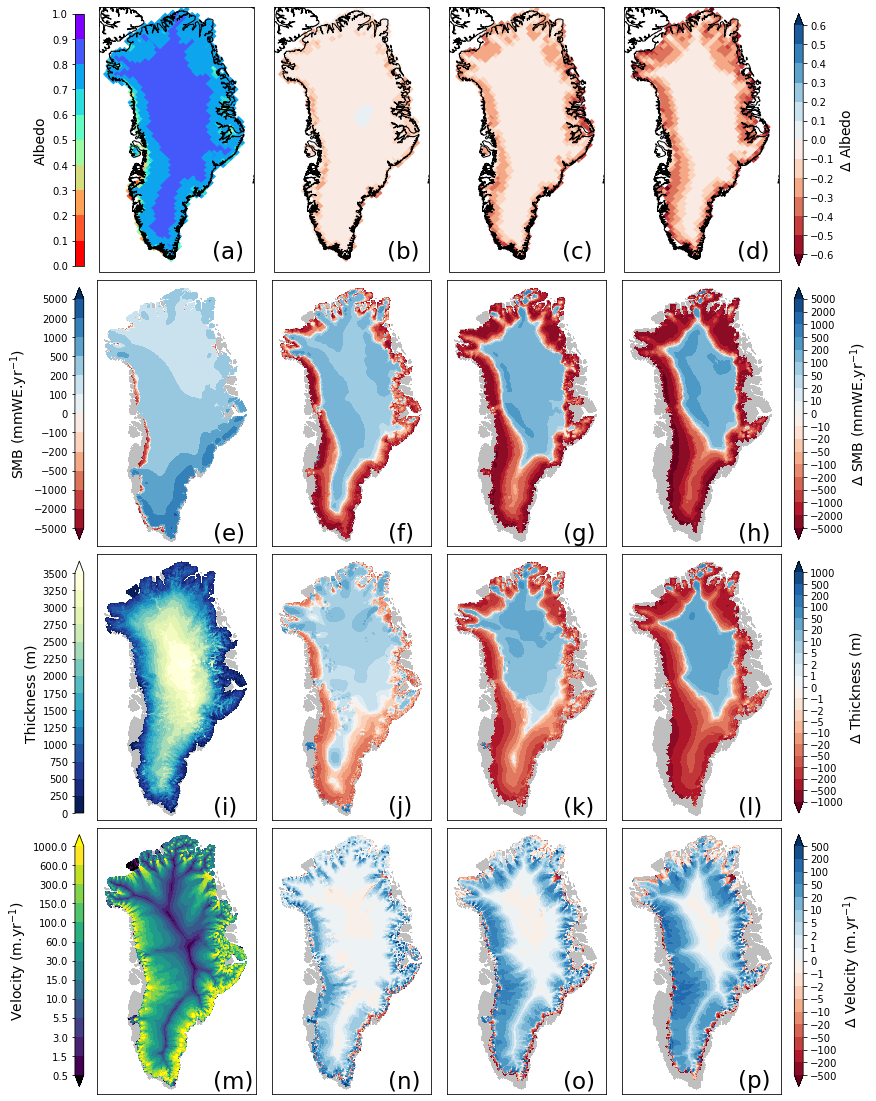

In [18]:
# Changes
fig = plt.figure(figsize = (12.26,20))
gs=GridSpec(4,4)
plt.rcParams['axes.titlepad'] =14

#---------------------------------------------albedo----------------------------------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.5, -29.5, 58, 84])
ax1.coastlines(resolution='10m', zorder=7)
#ax1.gridlines(zorder=8)
im1 = PolyCollection(ARCTIC_piControlend_albedo_JJA_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im1.set_array(ARCTIC_piControlend_albedo_JJA_var)
ax1.add_collection(im1)
ax1.text(500000, -3330000, '(a)', fontsize=23)

# colorbar
cbar_ax1 = fig.add_axes([0.1, 0.7, 0.01, 0.175])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', boundaries=bounds1, ticks=bounds1)
cb1.set_label(label='Albedo', size=14)
cb1.ax.tick_params(labelsize=10)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56.5, -29.5, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = PolyCollection(ARCTIC_stab_albedo_JJA_verts, cmap=cmap4, transform=crs_ll, norm=norm4,
                     **kwd_polycollection)
im2.set_array(ARCTIC_stab_albedo_JJA_var-ARCTIC_piControlend_albedo_JJA_var)
ax2.add_collection(im2)
ax2.text(500000, -3330000, '(b)', fontsize=23)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56.5, -29.5, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = PolyCollection(ARCTIC_mid_albedo_JJA_verts, cmap=cmap4, transform=crs_ll, norm=norm4,
                     **kwd_polycollection)
im3.set_array(ARCTIC_mid_albedo_JJA_var-ARCTIC_piControlend_albedo_JJA_var)
ax3.add_collection(im3)
ax3.text(500000, -3330000, '(c)', fontsize=23)

ax4 = plt.subplot(gs[3], projection=polar_stereographic)
ax4.set_extent([-56.5, -29.5, 58, 84])
ax4.coastlines(resolution='10m', zorder=7)
im4 = PolyCollection(ARCTIC_end_albedo_JJA_verts, cmap=cmap4, transform=crs_ll, norm=norm4,
                     **kwd_polycollection)
im4.set_array(ARCTIC_end_albedo_JJA_var-ARCTIC_piControlend_albedo_JJA_var)
ax4.add_collection(im4)
ax4.text(500000, -3330000, '(d)', fontsize=23)

# colorbar
cbar_ax4 = fig.add_axes([0.915, 0.7, 0.01, 0.175])
cb4 = fig.colorbar(im4, cax=cbar_ax4, orientation='vertical', boundaries=[-0.7]+bounds4+[0.7], ticks=bounds4, extend='both')
cb4.set_label(label=r'$\Delta$ Albedo', size=14)
cb4.ax.tick_params(labelsize=10)

#---------------------------------------------smb----------------------------------------------------
ax5 = plt.subplot(gs[4])
im5 = ax5.contourf(cism_x1, cism_y1, ARCTIC_piControlend_topg_yearly_mean.where(ARCTIC_piControlend_topg_yearly_mean>0).where(ARCTIC_piControlend_topg_yearly_mean<0, other=1), cmap='gray_r')
im5 = ax5.contourf(cism_x1, cism_y1, ARCTIC_piControlend_smb_4km_yearly_mean_masked, cmap=cmap5, norm=norm5, levels=bounds5, extend='both')
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(500000, -3330000, '(e)', fontsize=23)

# colorbar
cbar_ax5 = fig.add_axes([0.1, 0.51, 0.01, 0.175])
cb5 = fig.colorbar(im5, cax=cbar_ax5, orientation='vertical', boundaries=[-6000]+bounds5+[6000], ticks=bounds5)
cb5.set_label(label='SMB (mmWE.$\mathregular{yr^{-1}}$)', size=14)
cb5.ax.tick_params(labelsize=10)
cb5.ax.yaxis.set_ticks_position('left')
cb5.ax.yaxis.set_label_position('left')

ax6 = plt.subplot(gs[5])
im6 = ax6.contourf(cism_x1, cism_y1, ARCTIC_stab_topg_yearly_mean.where(ARCTIC_stab_topg_yearly_mean>0).where(ARCTIC_stab_topg_yearly_mean<0, other=1), cmap='gray_r')
im6 = ax6.contourf(cism_x1, cism_y1, ARCTIC_stab_smb_4km_yearly_mean_masked-ARCTIC_piControlend_smb_4km_yearly_mean_masked, cmap=cmap8, norm=norm8, levels=bounds8, extend='both')
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax6.text(500000, -3330000, '(f)', fontsize=23)

ax7 = plt.subplot(gs[6])
im7 = ax7.contourf(cism_x1, cism_y1, ARCTIC_mid_topg_yearly_mean.where(ARCTIC_mid_topg_yearly_mean>0).where(ARCTIC_mid_topg_yearly_mean<0, other=1), cmap='gray_r')
im7 = ax7.contourf(cism_x1, cism_y1, ARCTIC_mid_smb_4km_yearly_mean_masked-ARCTIC_piControlend_smb_4km_yearly_mean_masked, cmap=cmap8, norm=norm8, levels=bounds8, extend='both')
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(500000, -3330000, '(g)', fontsize=23)

ax8 = plt.subplot(gs[7])
im8 = ax8.contourf(cism_x1, cism_y1, ARCTIC_end_topg_yearly_mean.where(ARCTIC_end_topg_yearly_mean>0).where(ARCTIC_end_topg_yearly_mean<0, other=1), cmap='gray_r')
im8 = ax8.contourf(cism_x1, cism_y1, ARCTIC_end_smb_4km_yearly_mean_masked-ARCTIC_piControlend_smb_4km_yearly_mean_masked, cmap=cmap8, norm=norm8, levels=bounds8, extend='both')
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(500000, -3330000, '(h)', fontsize=23)

# colorbar
cbar_ax8 = fig.add_axes([0.915, 0.51, 0.01, 0.175])
cb8 = fig.colorbar(im8, cax=cbar_ax8, orientation='vertical', boundaries=[-12000]+bounds8+[12000], ticks=bounds8)
cb8.set_label(label=r'$\Delta$ SMB (mmWE.$\mathregular{yr^{-1}}$)', size=14)
cb8.ax.tick_params(labelsize=10)

#---------------------------------------------thk----------------------------------------------------
ax9 = plt.subplot(gs[8])
im9 = ax9.contourf(cism_x1, cism_y1, ARCTIC_piControlend_topg_yearly_mean.where(ARCTIC_piControlend_topg_yearly_mean>0).where(ARCTIC_piControlend_topg_yearly_mean<0, other=1), cmap='gray_r')
im9 = ax9.contourf(cism_x1, cism_y1, ARCTIC_piControlend_thk_yearly_mean_masked, cmap=cmap9, norm=norm9, levels=bounds9, extend='max')
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax9.text(500000, -3330000, '(i)', fontsize=23)

# colorbar
cbar_ax9 = fig.add_axes([0.1, 0.32, 0.01, 0.175])
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', boundaries=[-10]+bounds9+[4000], ticks=bounds9)
cb9.set_label(label='Thickness (m)', size=14)
cb9.ax.tick_params(labelsize=10)
cb9.ax.yaxis.set_ticks_position('left')
cb9.ax.yaxis.set_label_position('left')

ax10 = plt.subplot(gs[9])
im10 = ax10.contourf(cism_x1, cism_y1, ARCTIC_stab_topg_yearly_mean.where(ARCTIC_stab_topg_yearly_mean>0).where(ARCTIC_stab_topg_yearly_mean<0, other=1), cmap='gray_r')
im10 = ax10.contourf(cism_x1, cism_y1, ARCTIC_stab_thk_yearly_mean_masked-ARCTIC_piControlend_thk_yearly_mean_masked, cmap=cmap12, norm=norm12, levels=bounds12, extend='both')
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(500000, -3330000, '(j)', fontsize=23)

ax11 = plt.subplot(gs[10])
im11 = ax11.contourf(cism_x1, cism_y1, ARCTIC_mid_topg_yearly_mean.where(ARCTIC_mid_topg_yearly_mean>0).where(ARCTIC_mid_topg_yearly_mean<0, other=1), cmap='gray_r')
im11 = ax11.contourf(cism_x1, cism_y1, ARCTIC_mid_thk_yearly_mean_masked-ARCTIC_piControlend_thk_yearly_mean_masked, cmap=cmap12, norm=norm12, levels=bounds12, extend='both')
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11.text(500000, -3330000, '(k)', fontsize=23)

ax12 = plt.subplot(gs[11])
im12 = ax12.contourf(cism_x1, cism_y1, ARCTIC_end_topg_yearly_mean.where(ARCTIC_end_topg_yearly_mean>0).where(ARCTIC_end_topg_yearly_mean<0, other=1), cmap='gray_r')
im12 = ax12.contourf(cism_x1, cism_y1, ARCTIC_end_thk_yearly_mean_masked-ARCTIC_piControlend_thk_yearly_mean_masked, cmap=cmap12, norm=norm12, levels=bounds12, extend='both')
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax12.text(500000, -3330000, '(l)', fontsize=23)

# colorbar
cbar_ax12 = fig.add_axes([0.915, 0.32, 0.01, 0.175])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=[-1200]+bounds12+[1200], ticks=bounds12)
cb12.set_label(label=r'$\Delta$ Thickness (m)', size=14)
cb12.ax.tick_params(labelsize=10)

#---------------------------------------------velnorm----------------------------------------------------
ax13 = plt.subplot(gs[12])
im13 = ax13.contourf(cism_x1, cism_y1, ARCTIC_piControlend_topg_yearly_mean.where(ARCTIC_piControlend_topg_yearly_mean>0).where(ARCTIC_piControlend_topg_yearly_mean<0, other=1), cmap='gray_r')
im13 = ax13.contourf(cism_x0, cism_y0, ARCTIC_piControlend_velnorm_yearly_mean_masked, cmap=cmap13, norm=norm13, levels=bounds13, extend='both')
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax13.text(500000, -3330000, '(m)', fontsize=23)

# colorbar
cbar_ax13 = fig.add_axes([0.1, 0.13, 0.01, 0.175])
cb13 = fig.colorbar(im13, cax=cbar_ax13, orientation='vertical', boundaries=[0]+bounds13+[1200], ticks=bounds13)
cb13.set_label(label='Velocity (m.$\mathregular{yr^{-1}}$)', size=14)
cb13.ax.tick_params(labelsize=10)
cb13.ax.yaxis.set_ticks_position('left')
cb13.ax.yaxis.set_label_position('left')

ax14 = plt.subplot(gs[13])
im14 = ax14.contourf(cism_x1, cism_y1, ARCTIC_stab_topg_yearly_mean.where(ARCTIC_stab_topg_yearly_mean>0).where(ARCTIC_stab_topg_yearly_mean<0, other=1), cmap='gray_r')
im14 = ax14.contourf(cism_x0, cism_y0, ARCTIC_stab_velnorm_yearly_mean_masked-ARCTIC_piControlend_velnorm_yearly_mean_masked, cmap=cmap16, norm=norm16, levels=bounds16, extend='both')
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax14.text(500000, -3330000, '(n)', fontsize=23)

ax15 = plt.subplot(gs[14])
im15 = ax15.contourf(cism_x1, cism_y1, ARCTIC_mid_topg_yearly_mean.where(ARCTIC_mid_topg_yearly_mean>0).where(ARCTIC_mid_topg_yearly_mean<0, other=1), cmap='gray_r')
im15 = ax15.contourf(cism_x0, cism_y0, ARCTIC_mid_velnorm_yearly_mean_masked-ARCTIC_piControlend_velnorm_yearly_mean_masked, cmap=cmap16, norm=norm16, levels=bounds16, extend='both')
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax15.text(500000, -3330000, '(o)', fontsize=23)

ax16 = plt.subplot(gs[15])
im16 = ax16.contourf(cism_x1, cism_y1, ARCTIC_end_topg_yearly_mean.where(ARCTIC_end_topg_yearly_mean>0).where(ARCTIC_end_topg_yearly_mean<0, other=1), cmap='gray_r')
im16 = ax16.contourf(cism_x0, cism_y0, ARCTIC_end_velnorm_yearly_mean_masked-ARCTIC_piControlend_velnorm_yearly_mean_masked, cmap=cmap16, norm=norm16, levels=bounds16, extend='both')
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16.text(500000, -3330000, '(p)', fontsize=23)

# colorbar
cbar_ax16 = fig.add_axes([0.915, 0.13, 0.01, 0.175])
cb16 = fig.colorbar(im16, cax=cbar_ax16, orientation='vertical', boundaries=[-1000]+bounds16+[1000], ticks=bounds16)
cb16.set_label(label=r'$\Delta$ Velocity (m.$\mathregular{yr^{-1}}$)', size=14)
cb16.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_ARCTIC_dalbedo_JJA_dSMB_dthk_dvel_annual_4column_masked.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

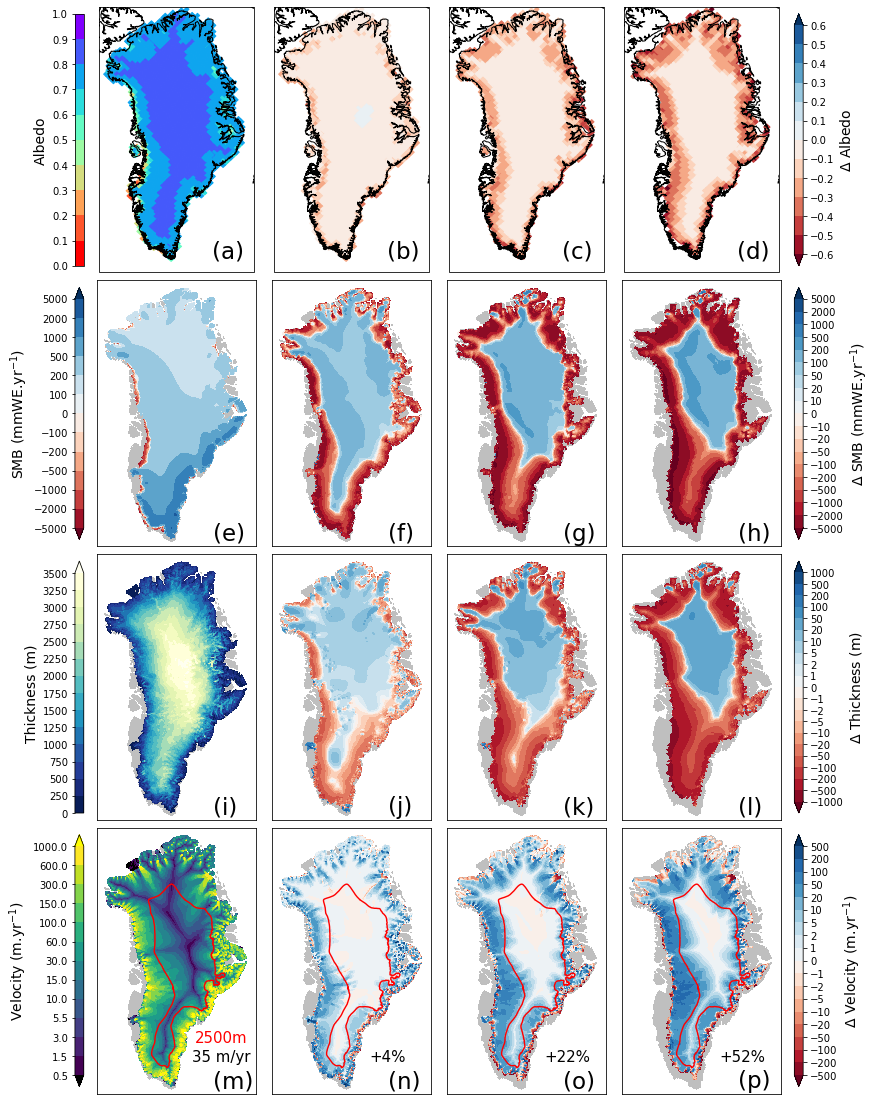

In [23]:
# Add numbers
fig = plt.figure(figsize = (12.26,20))
gs=GridSpec(4,4)
plt.rcParams['axes.titlepad'] =14

size_text = 15
elev_con = 2500
width_line = 1.4

#---------------------------------------------albedo----------------------------------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.5, -29.5, 58, 84])
ax1.coastlines(resolution='10m', zorder=7)
#ax1.gridlines(zorder=8)
im1 = PolyCollection(ARCTIC_piControlend_albedo_JJA_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im1.set_array(ARCTIC_piControlend_albedo_JJA_var)
ax1.add_collection(im1)
ax1.text(500000, -3330000, '(a)', fontsize=23)

# colorbar
cbar_ax1 = fig.add_axes([0.1, 0.7, 0.01, 0.175])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', boundaries=bounds1, ticks=bounds1)
cb1.set_label(label='Albedo', size=14)
cb1.ax.tick_params(labelsize=10)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56.5, -29.5, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = PolyCollection(ARCTIC_stab_albedo_JJA_verts, cmap=cmap4, transform=crs_ll, norm=norm4,
                     **kwd_polycollection)
im2.set_array(ARCTIC_stab_albedo_JJA_var-ARCTIC_piControlend_albedo_JJA_var)
ax2.add_collection(im2)
ax2.text(500000, -3330000, '(b)', fontsize=23)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56.5, -29.5, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = PolyCollection(ARCTIC_mid_albedo_JJA_verts, cmap=cmap4, transform=crs_ll, norm=norm4,
                     **kwd_polycollection)
im3.set_array(ARCTIC_mid_albedo_JJA_var-ARCTIC_piControlend_albedo_JJA_var)
ax3.add_collection(im3)
ax3.text(500000, -3330000, '(c)', fontsize=23)

ax4 = plt.subplot(gs[3], projection=polar_stereographic)
ax4.set_extent([-56.5, -29.5, 58, 84])
ax4.coastlines(resolution='10m', zorder=7)
im4 = PolyCollection(ARCTIC_end_albedo_JJA_verts, cmap=cmap4, transform=crs_ll, norm=norm4,
                     **kwd_polycollection)
im4.set_array(ARCTIC_end_albedo_JJA_var-ARCTIC_piControlend_albedo_JJA_var)
ax4.add_collection(im4)
ax4.text(500000, -3330000, '(d)', fontsize=23)

# colorbar
cbar_ax4 = fig.add_axes([0.915, 0.7, 0.01, 0.175])
cb4 = fig.colorbar(im4, cax=cbar_ax4, orientation='vertical', boundaries=[-0.7]+bounds4+[0.7], ticks=bounds4, extend='both')
cb4.set_label(label=r'$\Delta$ Albedo', size=14)
cb4.ax.tick_params(labelsize=10)

#---------------------------------------------smb----------------------------------------------------
ax5 = plt.subplot(gs[4])
im5 = ax5.contourf(cism_x1, cism_y1, ARCTIC_piControlend_topg_yearly_mean.where(ARCTIC_piControlend_topg_yearly_mean>0).where(ARCTIC_piControlend_topg_yearly_mean<0, other=1), cmap='gray_r')
im5 = ax5.contourf(cism_x1, cism_y1, ARCTIC_piControlend_smb_4km_yearly_mean_masked, cmap=cmap5, norm=norm5, levels=bounds5, extend='both')
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(500000, -3330000, '(e)', fontsize=23)

# colorbar
cbar_ax5 = fig.add_axes([0.1, 0.51, 0.01, 0.175])
cb5 = fig.colorbar(im5, cax=cbar_ax5, orientation='vertical', boundaries=[-6000]+bounds5+[6000], ticks=bounds5)
cb5.set_label(label='SMB (mmWE.$\mathregular{yr^{-1}}$)', size=14)
cb5.ax.tick_params(labelsize=10)
cb5.ax.yaxis.set_ticks_position('left')
cb5.ax.yaxis.set_label_position('left')

ax6 = plt.subplot(gs[5])
im6 = ax6.contourf(cism_x1, cism_y1, ARCTIC_stab_topg_yearly_mean.where(ARCTIC_stab_topg_yearly_mean>0).where(ARCTIC_stab_topg_yearly_mean<0, other=1), cmap='gray_r')
im6 = ax6.contourf(cism_x1, cism_y1, ARCTIC_stab_smb_4km_yearly_mean_masked-ARCTIC_piControlend_smb_4km_yearly_mean_masked, cmap=cmap8, norm=norm8, levels=bounds8, extend='both')
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax6.text(500000, -3330000, '(f)', fontsize=23)

ax7 = plt.subplot(gs[6])
im7 = ax7.contourf(cism_x1, cism_y1, ARCTIC_mid_topg_yearly_mean.where(ARCTIC_mid_topg_yearly_mean>0).where(ARCTIC_mid_topg_yearly_mean<0, other=1), cmap='gray_r')
im7 = ax7.contourf(cism_x1, cism_y1, ARCTIC_mid_smb_4km_yearly_mean_masked-ARCTIC_piControlend_smb_4km_yearly_mean_masked, cmap=cmap8, norm=norm8, levels=bounds8, extend='both')
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(500000, -3330000, '(g)', fontsize=23)

ax8 = plt.subplot(gs[7])
im8 = ax8.contourf(cism_x1, cism_y1, ARCTIC_end_topg_yearly_mean.where(ARCTIC_end_topg_yearly_mean>0).where(ARCTIC_end_topg_yearly_mean<0, other=1), cmap='gray_r')
im8 = ax8.contourf(cism_x1, cism_y1, ARCTIC_end_smb_4km_yearly_mean_masked-ARCTIC_piControlend_smb_4km_yearly_mean_masked, cmap=cmap8, norm=norm8, levels=bounds8, extend='both')
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(500000, -3330000, '(h)', fontsize=23)

# colorbar
cbar_ax8 = fig.add_axes([0.915, 0.51, 0.01, 0.175])
cb8 = fig.colorbar(im8, cax=cbar_ax8, orientation='vertical', boundaries=[-12000]+bounds8+[12000], ticks=bounds8)
cb8.set_label(label=r'$\Delta$ SMB (mmWE.$\mathregular{yr^{-1}}$)', size=14)
cb8.ax.tick_params(labelsize=10)

#---------------------------------------------thk----------------------------------------------------
ax9 = plt.subplot(gs[8])
im9 = ax9.contourf(cism_x1, cism_y1, ARCTIC_piControlend_topg_yearly_mean.where(ARCTIC_piControlend_topg_yearly_mean>0).where(ARCTIC_piControlend_topg_yearly_mean<0, other=1), cmap='gray_r')
im9 = ax9.contourf(cism_x1, cism_y1, ARCTIC_piControlend_thk_yearly_mean_masked, cmap=cmap9, norm=norm9, levels=bounds9, extend='max')
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax9.text(500000, -3330000, '(i)', fontsize=23)

# colorbar
cbar_ax9 = fig.add_axes([0.1, 0.32, 0.01, 0.175])
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', boundaries=[-10]+bounds9+[4000], ticks=bounds9)
cb9.set_label(label='Thickness (m)', size=14)
cb9.ax.tick_params(labelsize=10)
cb9.ax.yaxis.set_ticks_position('left')
cb9.ax.yaxis.set_label_position('left')

ax10 = plt.subplot(gs[9])
im10 = ax10.contourf(cism_x1, cism_y1, ARCTIC_stab_topg_yearly_mean.where(ARCTIC_stab_topg_yearly_mean>0).where(ARCTIC_stab_topg_yearly_mean<0, other=1), cmap='gray_r')
im10 = ax10.contourf(cism_x1, cism_y1, ARCTIC_stab_thk_yearly_mean_masked-ARCTIC_piControlend_thk_yearly_mean_masked, cmap=cmap12, norm=norm12, levels=bounds12, extend='both')
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(500000, -3330000, '(j)', fontsize=23)

ax11 = plt.subplot(gs[10])
im11 = ax11.contourf(cism_x1, cism_y1, ARCTIC_mid_topg_yearly_mean.where(ARCTIC_mid_topg_yearly_mean>0).where(ARCTIC_mid_topg_yearly_mean<0, other=1), cmap='gray_r')
im11 = ax11.contourf(cism_x1, cism_y1, ARCTIC_mid_thk_yearly_mean_masked-ARCTIC_piControlend_thk_yearly_mean_masked, cmap=cmap12, norm=norm12, levels=bounds12, extend='both')
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11.text(500000, -3330000, '(k)', fontsize=23)

ax12 = plt.subplot(gs[11])
im12 = ax12.contourf(cism_x1, cism_y1, ARCTIC_end_topg_yearly_mean.where(ARCTIC_end_topg_yearly_mean>0).where(ARCTIC_end_topg_yearly_mean<0, other=1), cmap='gray_r')
im12 = ax12.contourf(cism_x1, cism_y1, ARCTIC_end_thk_yearly_mean_masked-ARCTIC_piControlend_thk_yearly_mean_masked, cmap=cmap12, norm=norm12, levels=bounds12, extend='both')
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax12.text(500000, -3330000, '(l)', fontsize=23)

# colorbar
cbar_ax12 = fig.add_axes([0.915, 0.32, 0.01, 0.175])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=[-1200]+bounds12+[1200], ticks=bounds12)
cb12.set_label(label=r'$\Delta$ Thickness (m)', size=14)
cb12.ax.tick_params(labelsize=10)

#---------------------------------------------velnorm----------------------------------------------------
ax13 = plt.subplot(gs[12])
im13 = ax13.contourf(cism_x1, cism_y1, ARCTIC_piControlend_topg_yearly_mean.where(ARCTIC_piControlend_topg_yearly_mean>0).where(ARCTIC_piControlend_topg_yearly_mean<0, other=1), cmap='gray_r')
im13 = ax13.contourf(cism_x0, cism_y0, ARCTIC_piControlend_velnorm_yearly_mean_masked, cmap=cmap13, norm=norm13, levels=bounds13, extend='both')
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax13.text(500000, -3330000, '(m)', fontsize=23)
ax13.text(310000, -2850000, str(elev_con)+'m', fontsize=size_text, color='red')
ax13.text(280000, -3050000, '35 m/yr', fontsize=size_text, color='black')
plt.plot(p1[0].vertices[:,0], p1[0].vertices[:,1], color='red', linewidth=width_line)

# colorbar
cbar_ax13 = fig.add_axes([0.1, 0.13, 0.01, 0.175])
cb13 = fig.colorbar(im13, cax=cbar_ax13, orientation='vertical', boundaries=[0]+bounds13+[1200], ticks=bounds13)
cb13.set_label(label='Velocity (m.$\mathregular{yr^{-1}}$)', size=14)
cb13.ax.tick_params(labelsize=10)
cb13.ax.yaxis.set_ticks_position('left')
cb13.ax.yaxis.set_label_position('left')

ax14 = plt.subplot(gs[13])
im14 = ax14.contourf(cism_x1, cism_y1, ARCTIC_stab_topg_yearly_mean.where(ARCTIC_stab_topg_yearly_mean>0).where(ARCTIC_stab_topg_yearly_mean<0, other=1), cmap='gray_r')
im14 = ax14.contourf(cism_x0, cism_y0, ARCTIC_stab_velnorm_yearly_mean_masked-ARCTIC_piControlend_velnorm_yearly_mean_masked, cmap=cmap16, norm=norm16, levels=bounds16, extend='both')
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax14.text(500000, -3330000, '(n)', fontsize=23)
ax14.text(300000, -3050000, '+4%', fontsize=size_text, color='black')
plt.plot(p1[0].vertices[:,0], p1[0].vertices[:,1], color='red', linewidth=width_line)

ax15 = plt.subplot(gs[14])
im15 = ax15.contourf(cism_x1, cism_y1, ARCTIC_mid_topg_yearly_mean.where(ARCTIC_mid_topg_yearly_mean>0).where(ARCTIC_mid_topg_yearly_mean<0, other=1), cmap='gray_r')
im15 = ax15.contourf(cism_x0, cism_y0, ARCTIC_mid_velnorm_yearly_mean_masked-ARCTIC_piControlend_velnorm_yearly_mean_masked, cmap=cmap16, norm=norm16, levels=bounds16, extend='both')
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax15.text(500000, -3330000, '(o)', fontsize=23)
ax15.text(300000, -3050000, '+22%', fontsize=size_text, color='black')
plt.plot(p1[0].vertices[:,0], p1[0].vertices[:,1], color='red', linewidth=width_line)

ax16 = plt.subplot(gs[15])
im16 = ax16.contourf(cism_x1, cism_y1, ARCTIC_end_topg_yearly_mean.where(ARCTIC_end_topg_yearly_mean>0).where(ARCTIC_end_topg_yearly_mean<0, other=1), cmap='gray_r')
im16 = ax16.contourf(cism_x0, cism_y0, ARCTIC_end_velnorm_yearly_mean_masked-ARCTIC_piControlend_velnorm_yearly_mean_masked, cmap=cmap16, norm=norm16, levels=bounds16, extend='both')
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16.text(500000, -3330000, '(p)', fontsize=23)
ax16.text(300000, -3050000, '+52%', fontsize=size_text, color='black')
plt.plot(p1[0].vertices[:,0], p1[0].vertices[:,1], color='red', linewidth=width_line)

# colorbar
cbar_ax16 = fig.add_axes([0.915, 0.13, 0.01, 0.175])
cb16 = fig.colorbar(im16, cax=cbar_ax16, orientation='vertical', boundaries=[-1000]+bounds16+[1000], ticks=bounds16)
cb16.set_label(label=r'$\Delta$ Velocity (m.$\mathregular{yr^{-1}}$)', size=14)
cb16.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_ARCTIC_dalbedo_JJA_dSMB_dthk_dvel_annual_4column_masked_number.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)